## Load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import mean_squared_error as mse_score
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torchsummary import summary

In [2]:
train_data = pd.read_csv("/content/sample_data/california_housing_train.csv")
test_data  = pd.read_csv("/content/sample_data/california_housing_test.csv")
print(train_data.columns)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')


In [3]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           3000 non-null   float64
 1   latitude            3000 non-null   float64
 2   housing_median_age  3000 non-null   float64
 3   total_rooms         3000 non-null   float64
 4   total_bedrooms      3000 non-null   float64
 5   population          3000 non-null   float64
 6   households          3000 non-null   float64
 7   median_income       3000 non-null   float64
 8   median_house_value  3000 non-null   float64
dtypes: float64(9)
memory usage: 211.1 KB


In [4]:
train_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


<Axes: xlabel='median_house_value', ylabel='Count'>

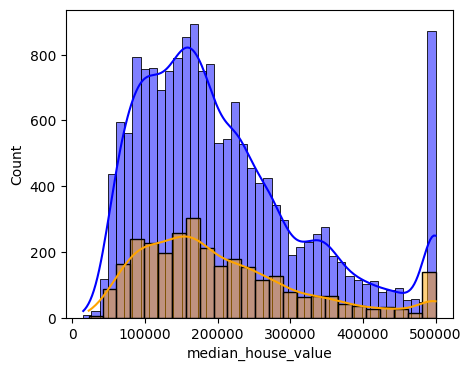

In [5]:
_, ax = plt.subplots(figsize=(5,4))
sns.histplot(train_data, x='median_house_value', kde=True, color="blue", ax=ax)
sns.histplot(test_data , x='median_house_value', kde=True, color="orange", ax=ax)

[]

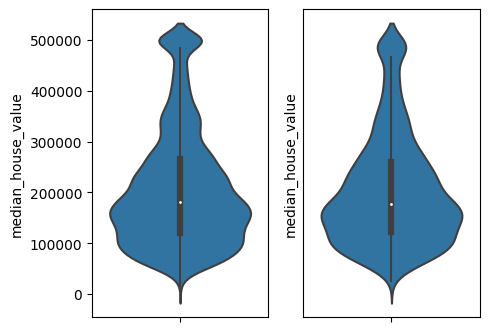

In [6]:
_, (ax1, ax2) = plt.subplots(1,2,figsize=(5,4))
sns.violinplot(train_data, y='median_house_value', ax=ax1)
sns.violinplot(test_data , y='median_house_value', ax=ax2)
ax2.set_yticks([])

In [7]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data  = scaler.transform(test_data)

In [8]:
print(train_data.min(), train_data.max(), test_data.min(), test_data.max())

0.0 1.0 0.0 1.0


In [49]:
X_train = train_data[:, :-1]
y_train = train_data[:, -1]

X_test = test_data[:, :-1]
y_test = test_data[:, -1]

X_train = X_train.reshape(-1, 1, 8)
X_test  = X_test.reshape(-1, 1, 8)
y_train = y_train.reshape(-1, 1)
y_test  = y_test.reshape(-1, 1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(17000, 1, 8) (3000, 1, 8) (17000, 1) (3000, 1)


## Create model

In [50]:
batch_size = 200
learning_rate = 1e-3
epochs = 50

In [53]:
model = nn.Sequential(
    nn.Conv1d(in_channels=1, out_channels=10, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv1d(in_channels=10, out_channels=30, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool1d(kernel_size=2),
    nn.Conv1d(in_channels=30, out_channels=40, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv1d(in_channels=40, out_channels=100, kernel_size=3, padding=1), nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=100*4, out_features=256), nn.ReLU(),
    nn.Linear(in_features=256, out_features=128), nn.ReLU(),
    nn.Linear(in_features=128, out_features=1), nn.Sigmoid()
)

summary(model, input_size=(1,8), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 10, 8]              40
              ReLU-2                [-1, 10, 8]               0
            Conv1d-3                [-1, 30, 8]             930
              ReLU-4                [-1, 30, 8]               0
         MaxPool1d-5                [-1, 30, 4]               0
            Conv1d-6                [-1, 40, 4]           3,640
              ReLU-7                [-1, 40, 4]               0
            Conv1d-8               [-1, 100, 4]          12,100
              ReLU-9               [-1, 100, 4]               0
          Flatten-10                  [-1, 400]               0
           Linear-11                  [-1, 256]         102,656
             ReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 128]          32,896
             ReLU-14                  [

In [54]:
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.cuda()
loss.cuda()

MSELoss()

In [55]:
losses = []
progress = tqdm(range(epochs), ncols=100)

for epoch in progress:
  #
  batch_losses = 0
  for i in range(0, len(train_data), batch_size):
    #
    batch_X = X_train[ i: i + batch_size ]
    batch_y = y_train[ i: i + batch_size ]
    batch_X = torch.from_numpy(batch_X).type(torch.FloatTensor).cuda()
    batch_y = torch.from_numpy(batch_y).type(torch.FloatTensor).cuda()

    ##----- Trainin cycle -----##
    optimizer.zero_grad()

    predictions = model(batch_X)

    batch_loss = loss(predictions, batch_y)

    batch_loss.backward()

    optimizer.step()
    #############################

    batch_losses += batch_loss.item()

  epoch_loss = batch_losses / (len(X_train)/batch_size)
  losses.append(epoch_loss)

  progress.set_description("[Epoch {0}/{1}] [Loss: {2:.5f}]".format(epoch, epochs, epoch_loss))

[Epoch 49/50] [Loss: 0.01747]: 100%|████████████████████████████████| 50/50 [00:13<00:00,  3.64it/s]


<Axes: >

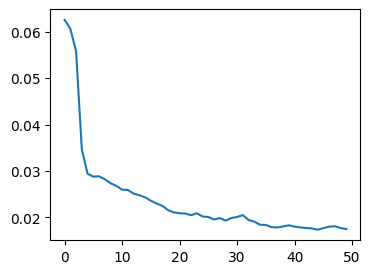

In [63]:
_, ax = plt.subplots(figsize=(4,3))
sns.lineplot(x=np.arange(len(losses)), y=losses, ax=ax)

In [69]:
predictions = []
progress = tqdm(range(0, len(X_test), batch_size))

for i in progress:
  #
  batch_X = X_test[i : i + batch_size]
  batch_X = torch.from_numpy(batch_X).type(torch.FloatTensor).cuda()

  batch_pred = model(batch_X)
  predictions.extend(batch_pred.detach().cpu().numpy())

predictions = np.array(predictions)
print (predictions.shape, y_train.shape)

100%|██████████| 15/15 [00:00<00:00, 839.95it/s]

(3000, 1) (17000, 1)


In [70]:
predictions.max()

0.999895

MSE: 0.020701544326758036


<Axes: ylabel='Count'>

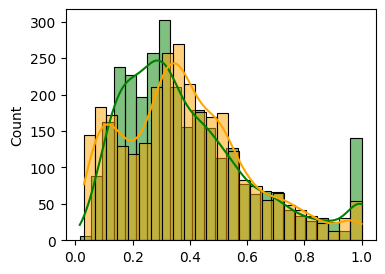

In [72]:
mse_ = mse_score(y_test.reshape(-1), predictions)

print ("MSE: {0}".format(mse_))

_, ax = plt.subplots(figsize=(4,3))
sns.histplot(x=y_test.reshape(-1), kde=True, color='green', ax=ax)
sns.histplot(x=predictions.reshape(-1), kde=True, color='orange', ax=ax)